In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.remove('/n/home12/binxuwang/.local/lib/python3.10/site-packages',)

In [1]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')

In [2]:
import os
os.environ["PYTHONNOUSERSITE"]='1'

In [4]:
#%%
import os
import re
import json
import pickle as pkl
from os.path import join
from tqdm import trange, tqdm
from os.path import join
from easydict import EasyDict as edict
# import torch
import numpy as np
import torch as th
import einops
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from edm_utils import parse_train_logfile
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error, saveallforms
from rule_utils import get_rule_list, get_obj_list, get_rule_img, check_consistent
from rule_new_utils import get_rule_annot

In [5]:
GPTroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"

In [6]:
!ls {GPTroot}/GPT2_base_RAVEN_uncond_heldout0-20240515-021155/samples

eval_epoch0.pt	 eval_epoch21.pt  eval_epoch33.pt  eval_epoch45.pt
eval_epoch10.pt  eval_epoch22.pt  eval_epoch34.pt  eval_epoch46.pt
eval_epoch11.pt  eval_epoch23.pt  eval_epoch35.pt  eval_epoch47.pt
eval_epoch12.pt  eval_epoch24.pt  eval_epoch36.pt  eval_epoch48.pt
eval_epoch13.pt  eval_epoch25.pt  eval_epoch37.pt  eval_epoch49.pt
eval_epoch14.pt  eval_epoch26.pt  eval_epoch38.pt  eval_epoch4.pt
eval_epoch15.pt  eval_epoch27.pt  eval_epoch39.pt  eval_epoch5.pt
eval_epoch16.pt  eval_epoch28.pt  eval_epoch3.pt   eval_epoch6.pt
eval_epoch17.pt  eval_epoch29.pt  eval_epoch40.pt  eval_epoch7.pt
eval_epoch18.pt  eval_epoch2.pt   eval_epoch41.pt  eval_epoch8.pt
eval_epoch19.pt  eval_epoch30.pt  eval_epoch42.pt  eval_epoch9.pt
eval_epoch1.pt	 eval_epoch31.pt  eval_epoch43.pt
eval_epoch20.pt  eval_epoch32.pt  eval_epoch44.pt


In [104]:
!ls {expdir}/ckpt

gpt2_ep19.pth  gpt2_ep39.pth  gpt2_ep9.pth    gpt2_init.pth
gpt2_ep29.pth  gpt2_ep49.pth  gpt2_final.pth


In [7]:
expname = "GPT2_base_RAVEN_uncond_heldout0-20240515-021155"
expname = "GPT2_big_pilot_fixed"
expname = "GPT2_big_RAVEN_uncond_heldout0-20240515-085510"
expdir = join(GPTroot, expname)

In [8]:
list(th.load(join(expdir, "samples", "eval_epoch2.pt")))

['eval_complete', 'C3_list', 'C2_list', 'rule_col_list']

### Individual Rule learning dynamics 

In [77]:
data = th.load(join(expdir, "samples", "eval_epoch5.pt"))

sample_tsr = data["eval_complete"]
C3_list = data["C3_list"]
C2_list = data["C2_list"]
rule_col_list = data["rule_col_list"]

rule_col_arr = np.array(rule_col_list, dtype=object)
# cond distribution 
cond_vec = rule_col_arr[:,0].astype(int)
rule_ids, cond_counts = np.unique(cond_vec, return_counts=True)
total_count_vec = np.zeros((40,), dtype=int)
total_count_vec[rule_ids] = cond_counts

C3_total = sum([len(C3) for C3 in C3_list if len(C3)>0])
rule_pool = np.concatenate(list(C3_list)).astype(int)
rule_ids, C3_rule_counts = np.unique(rule_pool, return_counts=True)
C3_count_vec = np.zeros((40,), dtype=int)
C3_count_vec[rule_ids] = C3_rule_counts

C2_total = sum([len(C2) for C2 in C2_list if len(C2)>0])
rule_pool = np.concatenate(list(C2_list)).astype(int)
rule_ids, C2_rule_counts = np.unique(rule_pool, return_counts=True)
C2_count_vec = np.zeros((40,), dtype=int)
C2_count_vec[rule_ids] = C2_rule_counts

In [9]:
total_count_mat = []
C3_count_mat = []
C2_count_mat = []
for epoch in range(50):
    data = th.load(join(expdir, "samples", f"eval_epoch{epoch}.pt"))
    
    sample_tsr = data["eval_complete"]
    C3_list = data["C3_list"]
    C2_list = data["C2_list"]
    rule_col_list = data["rule_col_list"]

    rule_col_arr = np.array(rule_col_list, dtype=object)
    # number of prompts following each rule. 
    cond_vec = rule_col_arr[:,0].astype(int)
    rule_ids, cond_counts = np.unique(cond_vec, return_counts=True)
    total_count_vec = np.zeros((40,), dtype=int)
    total_count_vec[rule_ids] = cond_counts

    C3_total = sum([len(C3) for C3 in C3_list if len(C3)>0])
    rule_pool = np.concatenate(list(C3_list)).astype(int)
    rule_ids, C3_rule_counts = np.unique(rule_pool, return_counts=True)
    C3_count_vec = np.zeros((40,), dtype=int)
    C3_count_vec[rule_ids] = C3_rule_counts

    C2_total = sum([len(C2) for C2 in C2_list if len(C2)>0])
    rule_pool = np.concatenate(list(C2_list)).astype(int)
    rule_ids, C2_rule_counts = np.unique(rule_pool, return_counts=True)
    C2_count_vec = np.zeros((40,), dtype=int)
    C2_count_vec[rule_ids] = C2_rule_counts
    total_count_mat.append(total_count_vec)
    C3_count_mat.append(C3_count_vec)
    C2_count_mat.append(C2_count_vec)
total_count_mat = np.array(total_count_mat)
C3_count_mat = np.array(C3_count_mat)
C2_count_mat = np.array(C2_count_mat)

/tmp/ipykernel_710377/3676335086.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cond_vec = rule_col_arr[:,0].astype(int)


In [10]:
def visualize_indiv_rule_dynam(epoch_list, rule_mat, conv_wid=10, heldout_id=[1, 16, 20, 34, 37],
                               titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(epoch_list, smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {rule_table[i]}")
        # change the font color of title to red
        if i in heldout_id:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

rule_table, relation_dict, attribute_dict = get_rule_annot()

/tmp/ipykernel_710377/2913490017.py:1: RuntimeWarning: invalid value encountered in divide
  figh, axs = visualize_indiv_rule_dynam(range(50), C3_count_mat / total_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37],


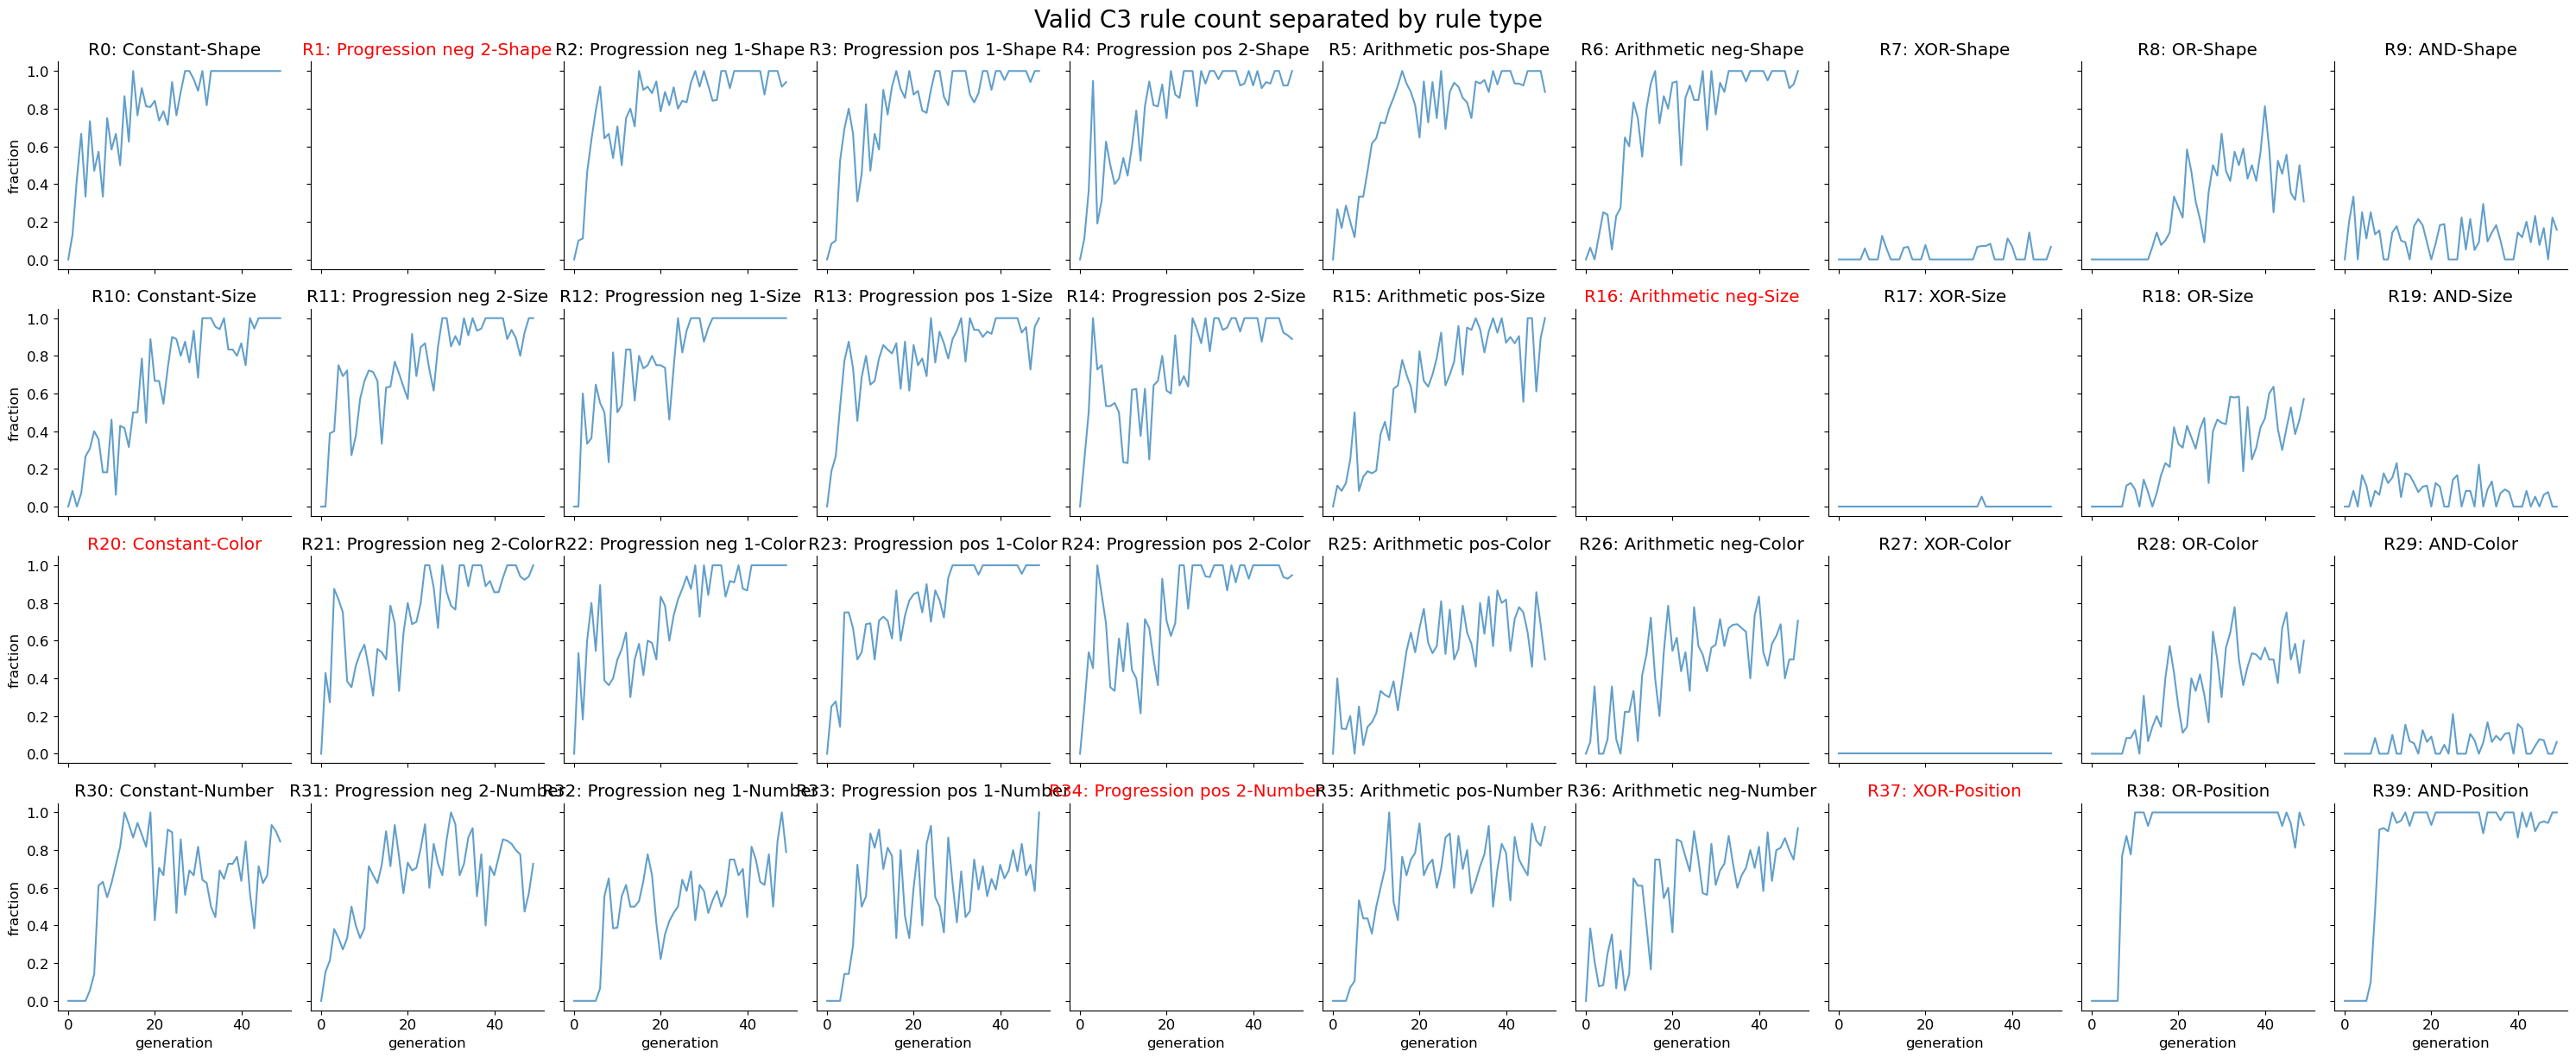

In [11]:
figh, axs = visualize_indiv_rule_dynam(range(50), C3_count_mat / total_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37], 
                                       titlestr="Valid C3 rule count separated by rule type", ylabel="fraction")

/tmp/ipykernel_3791783/889278872.py:1: RuntimeWarning: invalid value encountered in divide
  figh, axs = visualize_indiv_rule_dynam(range(50), (C2_count_mat) / total_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37],


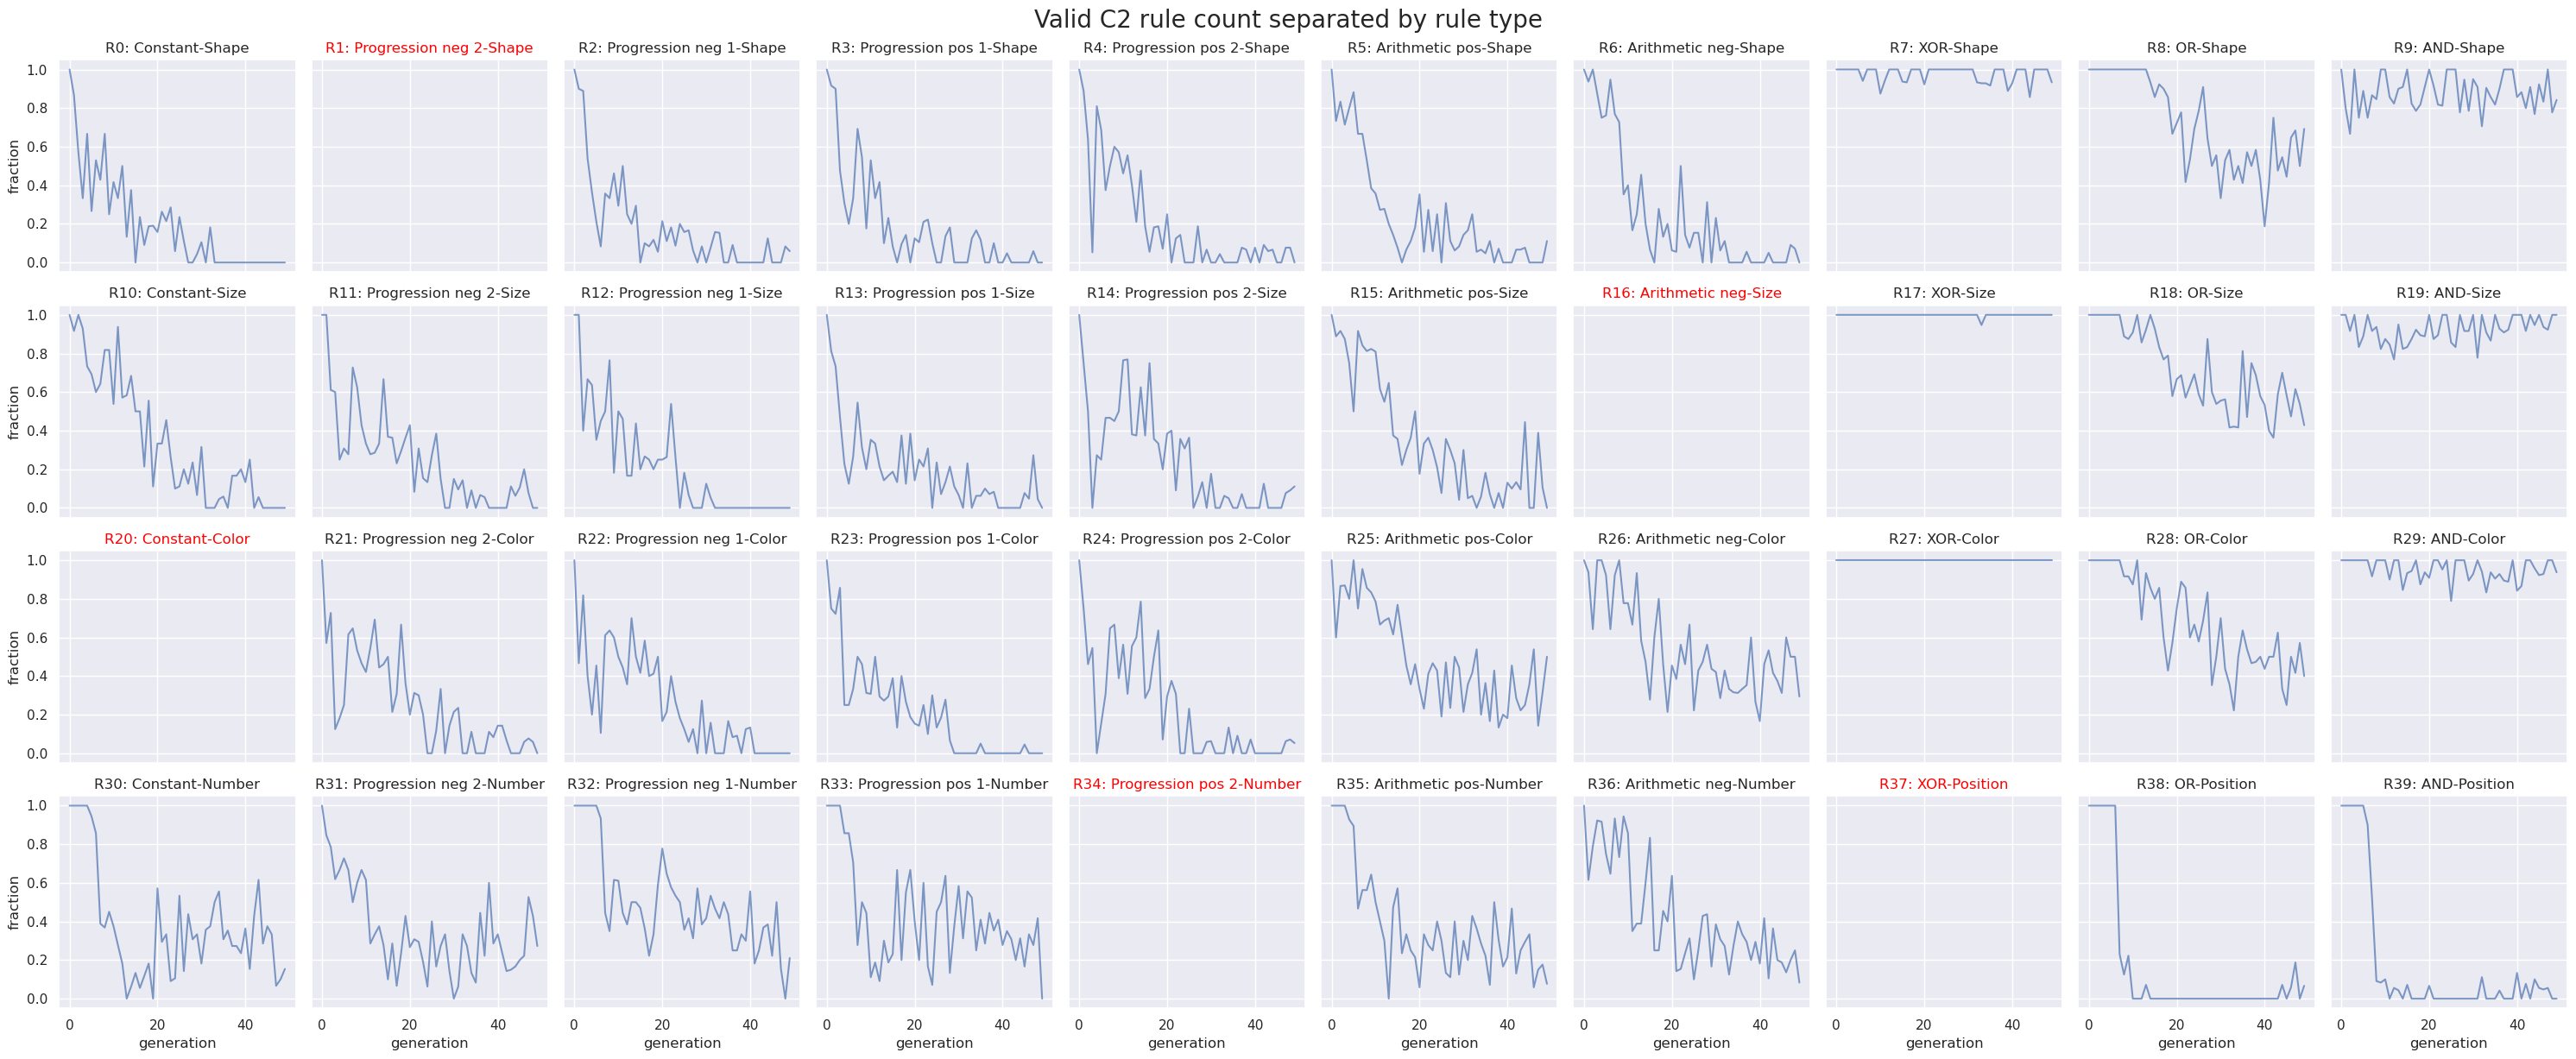

In [102]:
figh, axs = visualize_indiv_rule_dynam(range(50), (C2_count_mat) / total_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37], 
                                       titlestr="Valid C2 rule count separated by rule type", ylabel="fraction")

In [13]:
C3_rate_vec = C3_count_vec / total_count_vec
C2_rate_vec = C2_count_vec / total_count_vec

/tmp/ipykernel_710377/2756329930.py:1: RuntimeWarning: invalid value encountered in divide
  C3_rate_vec = C3_count_vec / total_count_vec
/tmp/ipykernel_710377/2756329930.py:2: RuntimeWarning: invalid value encountered in divide
  C2_rate_vec = C2_count_vec / total_count_vec


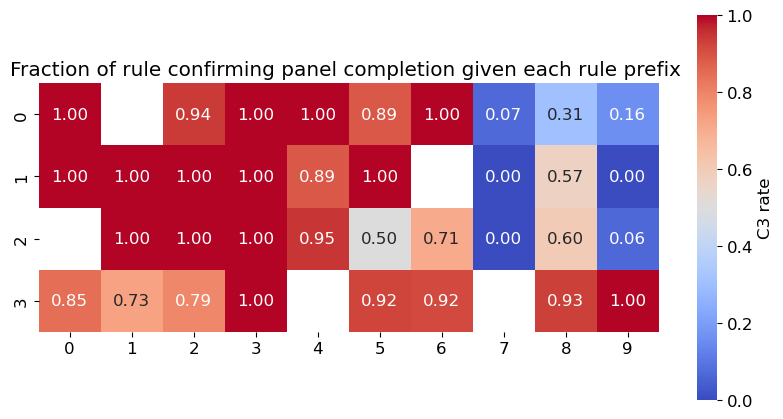

In [14]:
plt.figure(figsize=(10,5))
sns.heatmap(C3_rate_vec.reshape(4,10), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'C3 rate'},)
plt.title("Fraction of rule confirming panel completion given each rule prefix ")
plt.axis("image")
plt.show()

### Memorization 

In [67]:
import torch
import einops
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from os.path import join

def compute_min_l1_distances(sample_all, train_attrs, device, batchsize=32, visualize=False, epoch_list=None):
    minL1dist_col = {}
    train_attrs = train_attrs.to(device)
    for epochi in range(len(sample_all)):
        attr_panels = einops.rearrange(sample_all[epochi], 'b attr (row h) (p w) -> (b row) p (h w) attr', row=3, p=3)
        # shape of attr_panels: (b row) p (h w) attr | X,3,9,3
        minL1dist_mat, minimum_vec = [], []

        for i in trange(0, len(attr_panels), batchsize):
            L1dist = (train_attrs[None,] - attr_panels[i:i+batchsize].to(device)[:, None, None]).abs().sum(dim=(-1, -2, -3))
            minL1dist = L1dist.min(dim=-1).values
            minimum = minL1dist.min(dim=-1).values
            minL1dist_mat.append(minL1dist)
            minimum_vec.append(minimum)
        
        torch.cuda.empty_cache()

        minL1dist_mat = torch.cat(minL1dist_mat, dim=0).cpu()
        minimum_vec = torch.cat(minimum_vec, dim=0).cpu()
        minL1dist_col[epoch_list[epochi]] = minL1dist_mat

        if visualize:
            visualize_histogram(minimum_vec, epoch_list[epochi])
    
    return minL1dist_col

def compute_panel_level_min_l1_distances(sample_all, train_attrs_one_panel, device, batchsize_row=16, visualize=False, epoch_list=None):
    minL1dist_col_panel = {}
    # train_attrs_one_panel = einops.rearrange(train_attrs,
    #     'class B p pos attr -> class (B p) pos attr', pos=9, attr=3, p=3)
    train_attrs_one_panel = train_attrs_one_panel.to(device)
    for epochi in range(len(sample_all)):
        attr_one_panel = einops.rearrange(sample_all[epochi], 'b attr (row h) (p w) -> (b row p) (h w) attr', row=3, p=3)
        # shape of attr_one_panel: (b row p) (h w) attr | X,9,3
        minL1dist_mat_panel, minimum_vec_panel = [], []
        
        for i in trange(0, len(attr_one_panel), batchsize_row):
            L1dist = (train_attrs_one_panel[None,] - attr_one_panel[i:i+batchsize_row].to(device)[:, None, None]).abs().sum(dim=(-1, -2))
            minL1dist_panel = L1dist.min(dim=-1).values
            minimum_panel = minL1dist_panel.min(dim=-1).values
            minL1dist_mat_panel.append(minL1dist_panel)
            minimum_vec_panel.append(minimum_panel)
        
        torch.cuda.empty_cache()

        minL1dist_mat_panel = torch.cat(minL1dist_mat_panel, dim=0).cpu()
        minimum_vec_panel = torch.cat(minimum_vec_panel, dim=0).cpu()
        minL1dist_col_panel[epoch_list[epochi]] = minL1dist_mat_panel

        if visualize:
            visualize_histogram(minimum_vec_panel, epoch_list[epochi])
    
    return minL1dist_col_panel

def visualize_histogram(minimum_vec, epoch):
    print(pd.Series(minimum_vec.numpy()).describe())
    plt.hist(minimum_vec, bins=100)
    plt.xlabel('Minimum Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of minimum_vec (epoch {epoch})')
    plt.show()

def compute_memorization_stats(minL1dist_col, minL1dist_col_panel, epoch_list, expdir):
    mem_tab = []
    for epoch in minL1dist_col:
        minL1, minclass = minL1dist_col[epoch].min(dim=1)
        memfrac = (minL1 == 0).float().mean()
        row_memclass, row_memcnts = compute_memory_classes(minL1, minclass)
        
        minL1_panel, minclass_panel = minL1dist_col_panel[epoch].min(dim=1)
        memfrac_panel = (minL1_panel == 0).float().mean()
        panel_memclass, panel_memcnts = compute_memory_classes(minL1_panel, minclass_panel)
        
        mem_tab.append({"epoch": epoch, 
                        "row_memfrac": memfrac.item(),
                        "row_memclass": row_memclass,
                        "row_memcnts": row_memcnts,
                        "panel_memfrac": memfrac_panel.item(),
                        "panel_memclass": panel_memclass,
                        "panel_memcnts": panel_memcnts})
    
    mem_tab = pd.DataFrame(mem_tab)
    mem_tab.to_csv(join(expdir, "memorization_stats.csv"))
    print(mem_tab.tail())
    return mem_tab

def compute_memory_classes(minL1, minclass):
    if (minL1 == 0).float().mean() > 0:
        memclass, memcnts = torch.unique(minclass[minL1 == 0], return_counts=True)
        memcnts = memcnts.tolist()
        memclass = memclass.tolist()
    else:
        memclass = []
        memcnts = []
    return memclass, memcnts

def save_distances(minL1dist_col, minL1dist_col_panel, expdir):
    torch.save(minL1dist_col, join(expdir, "row_minL1dist_dict.pt"))
    torch.save(minL1dist_col_panel, join(expdir, "panel_minL1dist_dict.pt"))

def main(sample_all, train_attrs, train_attrs_one_panel, device, expdir, visualize=False, epoch_list=None):
    minL1dist_col = compute_min_l1_distances(sample_all, train_attrs, device, visualize=visualize, epoch_list=epoch_list)
    minL1dist_col_panel = compute_panel_level_min_l1_distances(sample_all, train_attrs_one_panel, device, visualize=visualize, epoch_list=epoch_list)
    
    save_distances(minL1dist_col, minL1dist_col_panel, expdir)
    
    mem_tab = compute_memorization_stats(minL1dist_col, minL1dist_col_panel, epoch_list, expdir)
    return mem_tab


What are deeper and other ways of looking at memorization? which part which position?
Where are the memorized panels located in the training sample?
Which attributes are memorized?

In [17]:
from GPT_models.GPT_RAVEN_model_lib import MultiIdxGPT2Model, completion_eval, seqtsr2imgtsr

In [20]:
expdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_big_RAVEN_uncond_heldout0-20240515-085510'

In [18]:
!cat {expdir}/config.json

{"batch_size": 64, "epoch_total": 50, "save_ckpt_every": 10, "lr": 0.0001, "num_warmup_steps": 100, "n_embd": 768, "n_class": 0, "n_layer": 24, "n_head": 12, "heldout_id": [1, 16, 20, 34, 37], "train_sample_num": 138250, "val_sample_num": 1750}

In [19]:

model_config = edict(json.load(open(join(expdir, "config.json"), "r")))
model_config.n_layer = 12
model_config.n_head = 12
# hacky way to fix this error
# Default config of GPT2Model. 
#     n_ctx=128,
#     n_embd=768,
#     n_layer=12,
#     n_head=12,

In [21]:
gpt2_big_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, **model_config)
gpt2_big_raven.load_state_dict(th.load(join(expdir, "ckpt", "gpt2_final.pth")))
gpt2_big_raven.to('cuda').eval();

Ab initio generation, sampling: 


  0%|          | 0/4 [00:00<?, ?it/s]

Completion: C3: 0.083 [170/2048],  valid: 0.414 [2545/6144]


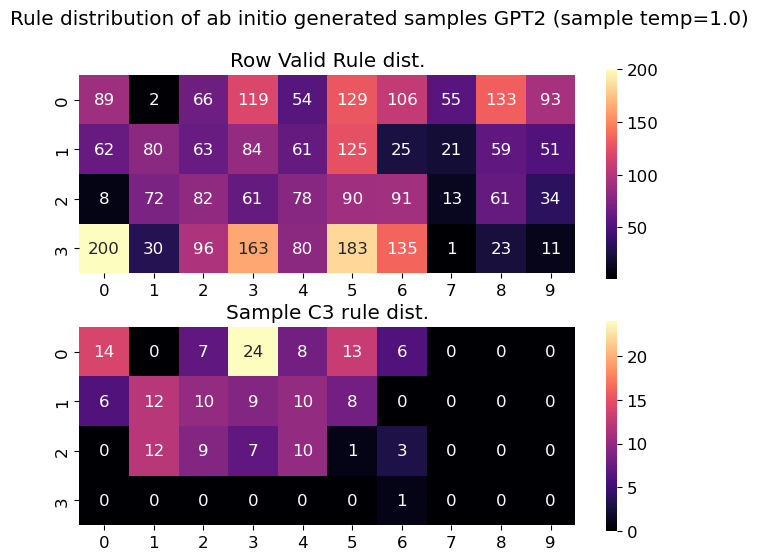

In [59]:
print("Ab initio generation, sampling: ")
temperature = 0.1
for temperature in [1.0]: #[1.0, 0.5, 0.2, 0.1]:
    eval_samples_empty = th.zeros(2048, 81, 3, dtype=th.long).to('cuda')
    eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_big_raven, num_mask=81, 
                                                device='cuda', strategy="sample", batch_size=256, temperature=temperature)
    C3_pooled = sum(C3_list, [])
    C3_pooled_arr = np.array(C3_pooled)
    rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
    rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
    rule_col_pooled_arr = np.concatenate(rule_col_pooled)
    rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
    C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
    rule_cnt_vec = np.zeros(40).astype(int)
    C3_rule_cnt_vec = np.zeros(40).astype(int)
    rule_cnt_vec[rule_uniq] = rule_cnt
    C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt
    figh,axs = plt.subplots(2,1, figsize=(8,6))
    plt.subplot(2,1,1)
    sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
    plt.axis('image')
    plt.title("Row Valid Rule dist.")
    plt.subplot(2,1,2)
    sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
    plt.axis('image')
    plt.title("Sample C3 rule dist.")
    plt.suptitle(f"Rule distribution of ab initio generated samples GPT2 (sample temp={temperature})")
    figh.show()

In [60]:
eval_complete_img = seqtsr2imgtsr(eval_complete, h=3, w=3, p=3, R=3)

In [62]:
th.cuda.empty_cache()

In [26]:
eval_complete_img[1].shape

torch.Size([3, 9, 9])

In [28]:
eval_complete_img.shape

torch.Size([2048, 3, 9, 9])

In [63]:
attr_all = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
attr_all_tsr = th.tensor(attr_all, dtype=th.int)
attrs_one_panel = einops.rearrange(attr_all_tsr,
        'class B p pos attr -> class (B p) pos attr', pos=9, attr=3, p=3)

In [70]:
minL1dist_col = compute_min_l1_distances([eval_complete_img], attr_all_tsr, "cuda", batchsize=32, visualize=False, epoch_list=[50])
th.cuda.empty_cache()
print((minL1dist_col[50]==0).sum())

  0%|          | 0/192 [00:00<?, ?it/s]

100%|██████████| 192/192 [00:06<00:00, 29.85it/s]


tensor(0)


In [68]:
minL1dist_col_panel = compute_panel_level_min_l1_distances([eval_complete_img], attrs_one_panel, "cuda", batchsize_row=16, visualize=False, epoch_list=[50])
th.cuda.empty_cache()
print((minL1dist_col_panel[50]==0).sum())

100%|██████████| 1152/1152 [00:20<00:00, 56.37it/s]


tensor(1053)


In [69]:
minL1dist_col_panel[50].shape

torch.Size([18432, 40])

In [72]:
minL1dist_reshape = minL1dist_col_panel[50].view(2048, 3, 3,-1)

In [75]:
minval, minidx = minL1dist_reshape.min(dim=-1)

In [78]:
minval.float().mean(dim=[0,1])

tensor([24.9121, 22.2184, 19.6704])

In [51]:
minL1dist_col_panel[50].shape

tensor([[ 5,  7,  6,  ...,  8,  8,  6],
        [25, 18, 24,  ..., 24, 21, 22],
        [ 1,  1,  0,  ...,  1,  5,  0],
        ...,
        [11, 11, 11,  ..., 34, 18, 20],
        [18, 14, 18,  ..., 15, 15, 14],
        [14, 21,  7,  ..., 21, 15, 27]])

In [52]:
minL1dist_col_panel[50].min(dim=1)

torch.Size([18432, 40])

In [48]:
print((minL1dist_col_panel[50]==0).sum())

tensor(45429)


In [49]:
print((minL1dist_col_panel[50]==0).float().mean())

tensor(0.0616)


In [50]:
minL1dist_col_panel[50].shape

torch.Size([18432, 40])

In [54]:
mem_tab = compute_memorization_stats(minL1dist_col, minL1dist_col_panel, [50], expdir)

   epoch  row_memfrac row_memclass row_memcnts  panel_memfrac  \
0     50          0.0           []          []       0.295139   

                                      panel_memclass  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                       panel_memcnts  
0  [1411, 909, 611, 488, 372, 237, 170, 6, 5, 27,...  


In [57]:
mem_tab.iloc[0].panel_memcnts  

[1411,
 909,
 611,
 488,
 372,
 237,
 170,
 6,
 5,
 27,
 124,
 166,
 114,
 59,
 70,
 57,
 51,
 3,
 54,
 48,
 43,
 28,
 35,
 24,
 26,
 2,
 36,
 44,
 41,
 33,
 24,
 28,
 23,
 28,
 20,
 23]